In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from multiprocess import Pool
import boto3
import joblib
import gensim
from plotnine import ggplot, aes, geoms, theme, element_blank, element_line, element_rect, element_text, scales, ggtitle, facet_wrap, ylim

w2v_model = gensim.models.Word2Vec.load("word2vec-model_bigrams.bin")
import joblib

client = boto3.client('s3')
%run Greene_dnmf.py

ModuleNotFoundError: No module named 'gensim'

In [ ]:
def similarity( w2v, ranking_i, ranking_j ):
    sim = 0.0
    pairs = 0
    for term_i in ranking_i:
        for term_j in ranking_j:
            try:
                sim += w2v.wv.similarity(term_i, term_j)
                pairs += 1
            except:
                pass
    if pairs == 0:
        return 0.0
    return sim/pairs

def tc_w2v(term_rankings,w2v):
    topic_scores = []
    overall = 0
    for index, topic in enumerate(term_rankings):
        score = similarity(w2v,topic,topic)
        topic_scores.append(score)
        overall += score
    overall /= len(term_rankings)
    return overall,topic_scores


In [2]:
def term_rankings(H,terms,ntop):
    term_rankings = []
    for topic_index in range(H.shape[0]):
        top_indices = np.argsort(H[topic_index,:])[::-1]
        term_ranking = [terms[i] for i in top_indices[:ntop]]
        term_rankings.append(term_ranking)
    return term_rankings

def get_top_words(vect):
    splits = [[z for z in i.split() if z in vocab] for i in vect]
    docs = [x for sublist in splits for x in sublist]
    counts = Counter(docs)
    top_10 = [i[0] for i in counts.most_common()][:20]
    return top_10

# make gensim dict and corpus, tfidf transform
procedural_stop_words = ['talk','thing','colleague','hear','floor','think','thank','insert','section','act_chair','amendment','clerk','clerk_designate',
                        'pursuant','minute','desk','amendment_text','amendment_desk','rule','debate','process','offer_amendment','majority','order',
                        'pass','extension','urge','urge_colleague','defeat_previous','yield_balance','member','committee','chairman','mr','subcommittee',
                        'rank_member','mr_chairman','oversight','yield_minute','yield_time','gentlewoman','gentleman','gentlelady','h_r','time_consume',
                        'legislation','measure','rollcall','rollcall_vote','vote_aye','vote_nay','nay','debate','point_order','chair','clause',
                        'clause_rule','germane','sustain','remark','conference','pass','oppose','offer','opposition','ask','speaker','bill',
                        'follow_prayer','approve_date','pledge_journal','morning_hour','today_adjourn','proceeding','deem_expire','reserve','complete',
                        'permit_speak','authorize_meet','session_senate','office_building','entitle','conduct_hearing','m_room','consent','ask_unanimous',
                        'dirksen_senate','senate_proceed','intervene_action','consider','notify_senate','senate','legislative_session','legislation',
                        'legislature','further_motion','motion','lay_table','motion_reconsider','reconsider','hearing','leader','p_m','a_m','period_morning',
                        'period_afternoon','executive_session','follow','senate_proceed','morning_business','authorize','motion_concur','concur','session',
                        'hour','control','follow_morning','senate_resume','follow','monday','tuesday','wednesday','thursday','friday','ask_unanimous',
                        'motion_reconsider','amendment','consent','motion_proceed','cloture','proceed','motion_invoke','cloture_motion','invoke',
                        'no_','modify','program','percent','increase','fund','funding','suspension', 'count', 'yesterday', 'tomorrow','act',
                        'previous_question', 'present', 'record','resolution', 'house_concurrent', 'house_joint', 'previous_question', 'yield_such',
                         'introduce', 'call', 're', 'recognize', 'commend', 'cosponsor', 'express', 'print', 'action', 'pursuant_house', 'h_re',
                         'continue', 'sponsor','yield', 'thank_gentleman', 'second', 'friend', 'comment', 'appreciate', 'gentleman_california',
                         'statement', 'distinguished', 'gentleman_texas', 'thank_gentlewoman', 'gentleman_ohio', 'gentleman_illinois', 'gentleman_pennsylvania',
                         'gentleman_florida', 'gentleman_michigan', 'want_commend', 'bring', 'special_order','house_representative', 'leadership', 'bring',
                         'consideration', 'matter', 'other_body', 'adjourn', 'legislative', 'version', 'move', 'meet', 'resolve', 'motion_instruct', 'appropriation_bill',
                        'madam_speaker', 'yield_such', 'reserve_balance', 'bipartisan', 'support_h', 'previous_question', 'introduce', 'important', 'good_friend',
                         'rise_today', 'pleased', 'sponsor', 'rise', 'like_thank', 'representative', 'second', 'want_thank', 'leadership', 'join', 'allow',
                        'consideration', 'discharge_further', 'ask_immediate', 'j_re', 'joint_resolution', 'immediate_consideration', 'week', 'senate_joint',
                         'designate', 'designate_week', 're', 'h_j','america','american','work','law','want','issue','get','try','take','let','question','answer',
                        'report','say','know','come','tell','people','country','language','conference','conference_report','need','see','commission',
                        'let','tell','day','united_state','deal','point','address','look','congress','congressional','go','come','put','agree','yield']

state_names = [i.lower() for i in ["Alaska", "Alabama", "Arkansas", "American_Samoa", "Arizona", "California", "Colorado", "Connecticut", "District_of_Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North_Carolina", "North_Dakota", "Nebraska", "New_Hampshire", "New_Jersey", "New_Mexico", "Nevada", "New_York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto_Rico", "Rhode_Island", "South_Carolina", "South_Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin_Islands", "Vermont", "Washington", "Wisconsin", "West_Virginia", "Wyoming"]]

procedural_stop_words.extend(state_names)

In [3]:
with open('procedural_stop_words.txt','w') as File:
    File.write(','.join(procedural_stop_words))

In [31]:
def run_window_NMF(info):
    party,congress = info

    k = 80
    DF = pd.read_csv(client.get_object(Bucket='ascsagemaker',
                                       Key=f'JMP_congressional_nmf/House_bigrams/{congress:0>3}_fixed_party.csv')['Body'])
    
    DF = DF.loc[-DF.party_y.isnull()]
    DF = DF.loc[(DF.chamber_x == 'H') & (DF.party_y == party[0])]
    DF['date'] = pd.to_datetime(DF.date)
    
    years = pd.to_datetime(DF.date).dt.year.unique() # what years are included in this congress
    if congress == 112:
        years = years[:2]
    models = []
    for year in years:
        sub_df = DF.loc[DF.date.dt.year == year]
        
        vectorizer = TfidfVectorizer(min_df=0.001,max_df=0.30,stop_words=procedural_stop_words,use_idf=True)
        dtm = vectorizer.fit_transform(sub_df.speech_processed)
        vocab = vectorizer.get_feature_names()

        model = NMF(n_components=k,max_iter=5000,init='nndsvd')
        W = model.fit_transform(dtm)
        H = model.components_
        print(f'{party} - {year} - {len(sub_df)} speeches')
        models.append({"W":W,"H":H,"vocab":vocab,"window_labels":[f'{party}_{year}_{i}' for i in range(100)],"DF_index":DF.index})
    return models

In [32]:
Info = [('Rep',i) for i in range(98,115)]
Info.extend([('Dem',i) for i in range(98,115)])

In [ ]:
with Pool(10) as p:
    output = p.map(run_window_NMF,Info)

Rep - 1997 - 9744 speeches
Rep - 1983 - 8116 speeches
Rep - 1987 - 9037 speeches
Rep - 1981 - 6420 speeches
Rep - 1993 - 9969 speeches
Rep - 1991 - 8871 speeches
Rep - 1995 - 16578 speeches
Rep - 1989 - 6934 speeches
Rep - 1985 - 10018 speeches
Rep - 1999 - 9606 speeches
Rep - 1994 - 8651 speeches
Rep - 1982 - 7857 speeches
Rep - 1992 - 7688 speeches
Rep - 1998 - 9463 speeches
Rep - 1986 - 8056 speeches
Rep - 1990 - 8782 speeches
Rep - 2000 - 9299 speeches
Rep - 2003 - 7396 speeches
Rep - 1984 - 9366 speeches
Rep - 1988 - 7581 speeches
Rep - 1996 - 10033 speeches
Rep - 2011 - 8722 speeches
Rep - 2005 - 8122 speeches
Rep - 2015 - 7781 speeches
Rep - 2001 - 7075 speeches
Rep - 2007 - 10534 speeches
Rep - 2013 - 7100 speeches
Rep - 2009 - 7008 speeches
Rep - 2004 - 6491 speeches
Dem - 1981 - 9944 speeches
Rep - 2006 - 7074 speeches
Rep - 2016 - 4952 speeches
Rep - 2012 - 6074 speeches
Rep - 2008 - 6418 speeches
Rep - 2010 - 6608 speeches
Dem - 1985 - 11567 speeches
Dem - 1982 - 11183 spee

In [34]:
outputs = [model for sublist in output for model in sublist]

In [35]:
for out in outputs:
    out['year'] = int(out['window_labels'][0].split('_')[1])
    out['party'] = out['window_labels'][0].split('_')[0]
    out['topics'] = term_rankings(out['H'],out['vocab'],ntop=10)

In [36]:
collection = TopicCollection()
for model in outputs:
    collection.add_topic_model(model['H'],model['vocab'],model['window_labels'])
    
Mat, full_vocab = collection.create_matrix()


In [37]:
for model in outputs:
    print(model['year'],model['party'])

1981 Rep
1982 Rep
1983 Rep
1984 Rep
1985 Rep
1986 Rep
1987 Rep
1988 Rep
1989 Rep
1990 Rep
1991 Rep
1992 Rep
1993 Rep
1994 Rep
1995 Rep
1996 Rep
1997 Rep
1998 Rep
1999 Rep
2000 Rep
2001 Rep
2002 Rep
2003 Rep
2004 Rep
2005 Rep
2006 Rep
2007 Rep
2008 Rep
2009 Rep
2010 Rep
2011 Rep
2012 Rep
2013 Rep
2014 Rep
2015 Rep
2016 Rep
1981 Dem
1982 Dem
1983 Dem
1984 Dem
1985 Dem
1986 Dem
1987 Dem
1988 Dem
1989 Dem
1990 Dem
1991 Dem
1992 Dem
1993 Dem
1994 Dem
1995 Dem
1996 Dem
1997 Dem
1998 Dem
1999 Dem
2000 Dem
2001 Dem
2002 Dem
2003 Dem
2004 Dem
2005 Dem
2006 Dem
2007 Dem
2008 Dem
2009 Dem
2010 Dem
2011 Dem
2012 Dem
2013 Dem
2014 Dem
2015 Dem
2016 Dem


In [ ]:
checks = []
for k in range(50,150,10):
    second_level = NMF(n_components=k,max_iter=5000,init='nndsvda')
    W = second_level.fit_transform(Mat)
    H = second_level.components_
    terms = term_rankings(H,full_vocab,ntop=20)
    tc = tc_w2v(terms,w2v_model)
    checks.append({"k":k,'tc':tc})
    print(k)

50
60
70
80
90
100
110


In [39]:
Ks = []
for level in checks:
    k = level['k']
    for tc in level['tc']:
        if type(tc) == list:
            for t in tc:
                Ks.append({"K":k,'tc':t})

In [43]:
model_df.groupby('K').tc.mean()

K
50     0.531194
60     0.528930
70     0.527905
80     0.529520
90     0.524320
100    0.523918
110    0.524478
120    0.520241
130    0.520570
140    0.517154
Name: tc, dtype: float64

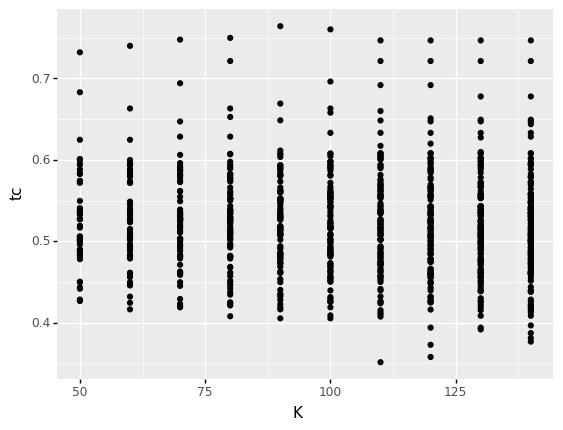

<ggplot: (8753082990838)>

In [41]:
model_df = pd.DataFrame(Ks)

(
ggplot(model_df,aes(x='K',y='tc',group='K')) +
    geoms.geom_point()
)

The process for labelling topics involves first reading the dynamic topic label and establishing a code from the CAP. next, the window topic descriptions are investigated to look for consistency with the main topic and label confirmed, window topics are labelled with more unique names, or a miss labelling is marked. After this procedure, a final close reading of 2 documents from each window are selected for final confirmation. 

In [44]:
second_level = NMF(n_components=120,max_iter=5000,init='nndsvd')
W = second_level.fit_transform(Mat)
H = second_level.components_
terms = term_rankings(H,full_vocab,ntop=10)

In [45]:
for ix,topic in enumerate(terms):
    print(ix)
    print(topic,end='\n')

0
['court', 'case', 'judge', 'supreme_court', 'decision', 'justice', 'constitution', 'claim', 'class_action', 'legal']
1
['correct', 'number', 'gentleman_yield', 'understanding', 'technical', 'figure', 'reflect', 'reference', 'necessary', 'conforming']
2
['vote', 'motion_recommit', 'final_passage', 'miss', 'defeat', 'voting', 'unable', 'detain', 'chance', 'cast']
3
['budget', 'budget_resolution', 'balance', 'priority', 'proposal', 'alternative', 'propose', 'fiscal', 'next_year', 'fiscal_year']
4
['child', 'parent', 'care', 'head_start', 'children', 'mother', 'abuse', 'adoption', 'young', 'foster_care']
5
['oil', 'price', 'natural_gas', 'consumer', 'pipeline', 'gas', 'sugar', 'drill', 'production', 'market']
6
['state', 'governor', 'department', 'local', 'union', 'federal_government', 'home', 'secretary', 'whole', 'grant']
7
['veteran', 'va', 'veteran_affair', 'benefit', 'compensation', 'care', 'vietnam_veteran', 'hospital', 'world_war', 'serve']
8
['president', 'veto', 'sign', 'white_h

In [60]:
import sys

In [123]:
Final = {"window_models":outputs,"dynamic_model":{"k":120,'H':H,'W':W,'collection_mat':Mat,'collection_vocab':full_vocab},'mapper':mapper}

In [94]:
outputs[0]['DF_index']

Int64Index([   85,    87,    88,    89,    90,    91,    92,    93,    94,
               95,
            ...
            77805, 77809, 77810, 77811, 77814, 77816, 77818, 77819, 77820,
            77821],
           dtype='int64', length=14277)

In [71]:
dynamic_labels = pd.read_csv('120 topics.csv')

In [124]:
with open('Official_results_final_models.pkl','wb') as File:
    joblib.dump(Final,File)

In [95]:
dynamic_labels

,dynamic_topic_ix,Major Topic,Sub_topic
0,0,NaN,NaN
1,1,procedural,NaN
2,2,macroeconomics,national budget
3,3,government operations,intergovernmental relations
4,4,procedural,NaN
...,...,...,...
115,115,defense,foreign operations
116,116,health,medical facilities
117,117,NaN,NaN
118,118,law crime,white collar crime


In [ ]:
# assigned_topics = W.argmax(1)
# assigned_labels = [dynamic_labels['Major Topic'].values[i] for i in assigned_topics]
# mapper = []
# for i in range(len(collection.topic_ids)):
#     party,year,topic = collection.topic_ids[i].split('_')
#     topic_label = assigned_labels[i]
#     topic_ix = assigned_topics[i]
#     mapper.append({"party":party,'year':year,'topic_id':topic,'dynamic_label':topic_label})

# mapper = pd.DataFrame(mapper)

# def get_topic_terms(x):
#     party = x['party']
#     year = int(x['year'])
#     ix = int(x['topic_id'])
#     for out in outputs:
#         if out['year'] == year and out['party'] == party:
#             return out['topics'][ix]
        
        
# mapper['window_terms'] = mapper.apply(get_topic_terms,1)
# mapper = mapper.sort_values(by='year',ascending=True)

In [116]:
party,year,topic = collection.topic_ids[1].split('_')

In [119]:
assigned_topics[1]

10

In [120]:
mapper

,party,year,topic_id,dynamic_label,window_terms
0,Rep,1981,0,28,"[land, county, federal, agricultural, resource..."
2551,Dem,1981,31,23,"[want, give, see, help, job, good, way, put, f..."
2550,Dem,1981,30,111,"[request, amount, reduction, supplemental, tot..."
2549,Dem,1981,29,6,"[child, woman, family, mother, care, parent, s..."
2548,Dem,1981,28,10,"[rate, high_interest, interest_rate, economic,..."
...,...,...,...,...,...
2497,Rep,2016,47,105,"[bank, financial_institution, financial, small..."
2498,Rep,2016,48,104,"[go, look, come, happen, see, know, number, te..."
2499,Rep,2016,49,91,"[internet, fcc, regulate, rate, broadband, con..."
2493,Rep,2016,43,20,"[small_business, access_capital, contract, bus..."


In [49]:
assigned_topics = W.argmax(1)

mapper = []
for i in range(len(collection.topic_ids)):
    party,year,topic = collection.topic_ids[i].split('_')
    topic_label = assigned_topics[i]
    mapper.append({"party":party,'year':year,'topic_id':topic,'dynamic_label':topic_label})

mapper = pd.DataFrame(mapper)

def get_topic_terms(x):
    party = x['party']
    year = int(x['year'])
    ix = int(x['topic_id'])
    for out in outputs:
        if out['year'] == year and out['party'] == party:
            return out['topics'][ix]
        
        
mapper['window_terms'] = mapper.apply(get_topic_terms,1)
mapper = mapper.sort_values(by='year',ascending=True)

In [50]:
mapper

,party,year,topic_id,dynamic_label,window_terms
0,Rep,1981,0,8,"[president, president_reagan, proposal, plan, ..."
2901,Dem,1981,21,86,"[voting_right, minority, right, voting, citize..."
2902,Dem,1981,22,13,"[tax, way_mean, tax_cut, taxis, small_business..."
2903,Dem,1981,23,104,"[rate, high_interest, interest_rate, small_bus..."
2904,Dem,1981,24,39,"[law_enforcement, drug, arrest, equipment, age..."
...,...,...,...,...,...
2855,Rep,2016,55,75,"[north_korea, north_korean, regime, sanction, ..."
2856,Rep,2016,56,43,"[housing, public_housing, opportunity, hud, as..."
2857,Rep,2016,57,54,"[medicaid, care, patient, provider, physician,..."
2839,Rep,2016,39,84,"[employee, federal, hire, employer, official, ..."


In [55]:
val = 117
print("---------------------------------------------------")
print(terms[val])
print("---------------------------------------------------\n\n")
for i in mapper.loc[mapper.dynamic_label == val].iterrows():
    print(i[1]['party'] + '-' + i[1]['year'] + '-' + i[1]['topic_id'])
    print(i[1]['window_terms'])
    print('________________________\n')

---------------------------------------------------
['gun', 'firearm', 'gun_violence', 'weapon', 'criminal', 'ban', 'handgun', 'background_check', 'assault_weapon', 'kill']
---------------------------------------------------


Dem-1986-25
['handgun', 'gun', 'firearm', 'crime', 'law_enforcement', 'criminal', 'dealer', 'volkmer', 'sportsman', 'police']
________________________

Rep-1986-45
['handgun', 'firearm', 'volkmer_substitute', 'gun', 'law_enforcement', 'criminal', 'sportsman', 'transport', 'crime', 'hughe']
________________________

Dem-1988-45
['handgun', 'crime', 'gun', 'brady', 'hate_crime', 'law_enforcement', 'police', 'firearm', 'wait_period', 'violence']
________________________

Dem-1989-65
['production', 'weapon', 'arm_control', 'chemical_weapon', 'plutonium', 'agreement', 'negotiation', 'ban', 'treaty', 'produce']
________________________

Rep-1991-32
['brady_bill', 'criminal', 'gun', 'stagger', 'handgun', 'brady', 'system', 'background_check', 'check', 'firearm']
_______